In [1]:
%pip install sortedcontainers

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
from functools import cmp_to_key
import numpy as np
import random
from sortedcontainers import SortedList

In [3]:
def orientation(p, q, r):
    """
    Para determinar a orientação do conjunto ordenado (p, q, r).
    Se o resultado for positivo, então a orientação é no sentido horário.
    Se o resultado for negativo, então a orientação é no sentido anti-horário.
    Se o resultado for 0, então p, q e r são colineares.
    """
    return (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)

def on_segment(p, q, r):
    """Verifica se o ponto q está no segmento definido pelos pontos p e r."""
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

In [4]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False


    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

    def __eq__(self, other):
        return self.p1.y == other.p1.y and self.p2.y == other.p2.y

In [5]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            return (p1.distancia_ao_quadrado(p0) <= p2.distancia_ao_quadrado(p0)) - 1
        return 1 if o > 0 else -1
    return compare


In [6]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        # Enquanto a orientação não for anti-horária, remova o último ponto
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    # Fechar a envoltória
    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria


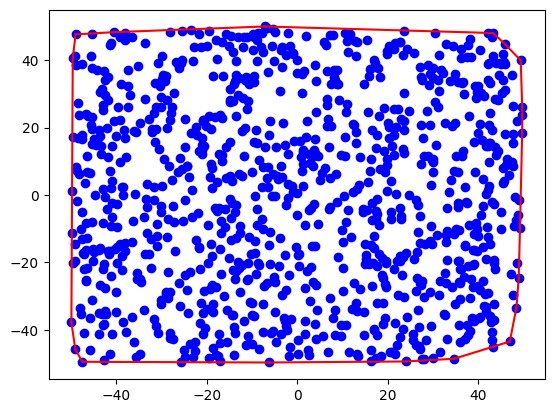

In [7]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)


In [8]:
def segmentos_que_se_cruzam(segmentos, poligonos):
    # Criar eventos
    eventos = []
    for seg, poligono in zip(segmentos, poligonos):
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg, poligono))
        eventos.append((end, 'end', seg, poligono))
    
    # Ordenar eventos
    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    def order_by_y(segment):
        return (segment.p1.y + segment.p2.y) / 2

    ordenacao_y = SortedList(key=order_by_y)
    intersecoes = set()

    # Processar eventos
    for ponto, tipo, segmento, poligono in eventos:
        if tipo == 'start':
            idx = ordenacao_y.bisect(segmento)
            
            # Verificar interseção com segmento abaixo
            if idx > 0:
                seg_below = ordenacao_y[idx - 1]
                if segmento.intersecao(seg_below) and poligonos[segmentos.index(segmento)] != poligonos[segmentos.index(seg_below)]:
                    intersecoes.add(tuple(sorted([segmento, seg_below])))

            # Verificar interseção com segmento acima
            if idx < len(ordenacao_y) - 1:
                seg_above = ordenacao_y[idx + 1]
                if segmento.intersecao(seg_above) and poligonos[segmentos.index(segmento)] != poligonos[segmentos.index(seg_above)]:
                    intersecoes.add(tuple(sorted([segmento, seg_above])))

            ordenacao_y.add(segmento)
        else:
            segmento_idx = ordenacao_y.index(segmento)
            
            # Verificar interseção entre segmentos vizinhos
            if 0 < segmento_idx < len(ordenacao_y) - 1:
                seg_below = ordenacao_y[segmento_idx - 1]
                seg_above = ordenacao_y[segmento_idx + 1]
                if seg_below.intersecao(seg_above) and poligonos[segmentos.index(seg_below)] != poligonos[segmentos.index(seg_above)]:
                    intersecoes.add(tuple(sorted([seg_below, seg_above])))
            
            ordenacao_y.remove(segmento)
    
    return list(intersecoes)



def plot_segmentos(segmentos):
    """Plota os segmentos e destaca aqueles que se cruzam."""
    intersecoes = segmentos_que_se_cruzam(segmentos)
    for segmento in segmentos:
        plt.plot([segmento.p1.x, segmento.p2.x], [segmento.p1.y, segmento.p2.y], 'b-')

    for seg1, seg2 in intersecoes:
        plt.plot([seg1.p1.x, seg1.p2.x], [seg1.p1.y, seg1.p2.y], 'b-')
        plt.plot([seg2.p1.x, seg2.p2.x], [seg2.p1.y, seg2.p2.y], 'b-')

    plt.show()

In [9]:
# Exemplo de uso:
s1 = Segmento(Ponto(1, 1), Ponto(3, 3))
s2 = Segmento(Ponto(1, 10), Ponto(10, 1))
s3 = Segmento(Ponto(2, 3), Ponto(0, 6))
s4 = Segmento(Ponto(5, 5), Ponto(8, 5))

segmentos = [s1, s2, s3, s4]
plot_segmentos(segmentos)

TypeError: segmentos_que_se_cruzam() missing 1 required positional argument: 'poligonos'

[[(90, 26), (0, 76)], [(56, 76), (68, 16)], [(47, 16), (33, 61)], [(75, 64), (91, 88)], [(66, 51), (56, 34)]]
Os segmentos [(47, 16), (33, 61)] e [(90, 26), (0, 76)] se cruzam.
Os segmentos [(66, 51), (56, 34)] e [(90, 26), (0, 76)] se cruzam.
Os segmentos [(56, 76), (68, 16)] e [(90, 26), (0, 76)] se cruzam.
Os segmentos [(56, 76), (68, 16)] e [(66, 51), (56, 34)] se cruzam.


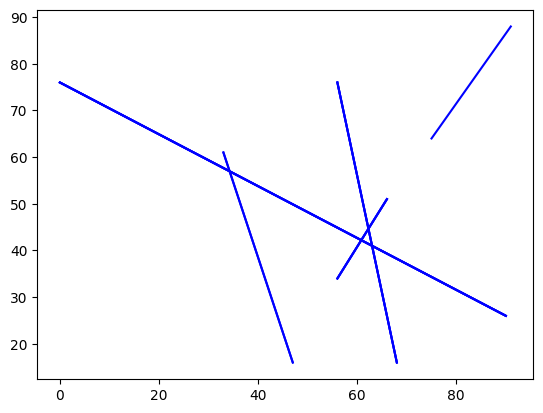

In [ ]:
def segmentos_aleatorios(num_segmentos, limite_x, limite_y):
    """Gera uma lista de segmentos aleatórios."""
    segmentos = []
    for _ in range(num_segmentos):
        x1, y1, x2, y2 = random.randint(0, limite_x), random.randint(0, limite_y), random.randint(0, limite_x), random.randint(0, limite_y)
        segmentos.append(Segmento(Ponto(x1, y1), Ponto(x2, y2)))
    return segmentos

# Gerar 10 segmentos aleatórios dentro de uma área de 100x100
segmentos = segmentos_aleatorios(5, 100, 100)
print(segmentos)
plot_segmentos(segmentos)

In [ ]:

def verificar_separabilidade_linear(envoltoria_classe_1, envoltoria_classe_2):
    # Função que verifica se há interseção entre segmentos das envoltórias
    def segmentos_se_intersectam(segmento1, segmento2):
        return segmento1.intersecao(segmento2)

    # Criando segmentos a partir de cada pontos das envoltórias de ambas as classes
    segmentos_classe_1 = [Segmento(envoltoria_classe_1[i], envoltoria_classe_1[i + 1]) for i in range(len(envoltoria_classe_1) - 1)]
    segmentos_classe_2 = [Segmento(envoltoria_classe_2[i], envoltoria_classe_2[i + 1]) for i in range(len(envoltoria_classe_2) - 1)]

    # Verifique a interseção entre segmentos das envoltórias de diferentes classes
    for segmento1 in segmentos_classe_1:
        for segmento2 in segmentos_classe_2:
            if segmentos_se_intersectam(segmento1, segmento2):
                # Se houver interseção entre qualquer par de segmentos, os pontos das envoltórias se cruzam
                return False

    # Se nenhum par de segmentos se intersectar, os dados são linearmente separáveis
    return True

In [ ]:
def encontrar_pontos_mais_proximos(envoltoria_classe_1, envoltoria_classe_2):
    # Encontre os pontos mais próximos entre as duas envoltórias
    menor_distancia = float('inf')
    ponto1 = None
    ponto2 = None

    for ponto1_classe_1 in envoltoria_classe_1:
        for ponto2_classe_2 in envoltoria_classe_2:
            distancia = ponto1_classe_1.distancia_ao_quadrado(ponto2_classe_2)
            if distancia < menor_distancia:
                menor_distancia = distancia
                ponto1 = ponto1_classe_1
                ponto2 = ponto2_classe_2

    return ponto1, ponto2

def construir_modelo_linear(envoltoria_classe_1, envoltoria_classe_2):
    # Encontre os pontos mais próximos entre as duas envoltórias
    ponto1, ponto2 = encontrar_pontos_mais_proximos(envoltoria_classe_1, envoltoria_classe_2)

    # Calcule o ponto médio entre os pontos mais próximos
    ponto_medio = Ponto((ponto1.x + ponto2.x) / 2, (ponto1.y + ponto2.y) / 2)

    # Calcule o vetor direção do segmento que une os pontos mais próximos
    vetor_direcao = Ponto(ponto2.x - ponto1.x, ponto2.y - ponto1.y)

    # Calcule o vetor direção da reta perpendicular
    vetor_direcao_perpendicular = Ponto(vetor_direcao.y, -vetor_direcao.x)

    # Use o ponto médio como ponto na reta e o vetor direção da reta perpendicular
    coeficiente_angular = vetor_direcao_perpendicular.y / vetor_direcao_perpendicular.x
    coeficiente_linear = ponto_medio.y - coeficiente_angular * ponto_medio.x

    # O modelo linear será da forma y = mx + b
    modelo_linear = (coeficiente_angular, coeficiente_linear)

    return modelo_linear


Os dados são linearmente separáveis.
Modelo Linear: (-1.9345748906644151, 122.42658906468407)


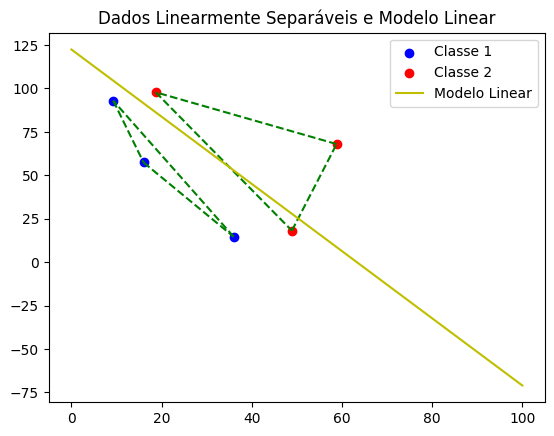

In [ ]:
#Teste de uso:

# Gerar duas classes de pontos aleatórios
classe_1 = [Ponto(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(3)]
classe_2 = [Ponto(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(3)]

# Calcular as envoltórias convexas de cada classe
envoltoria_classe_1 = graham_scan(classe_1)
envoltoria_classe_2 = graham_scan(classe_2)

separabilidade_linear = verificar_separabilidade_linear(envoltoria_classe_1, envoltoria_classe_2)

# Plotar os pontos e as envoltórias
plt.scatter([p.x for p in classe_1], [p.y for p in classe_1], color='b', label='Classe 1')
plt.scatter([p.x for p in classe_2], [p.y for p in classe_2], color='r', label='Classe 2')

for i in range(len(envoltoria_classe_1) - 1):
    plt.plot([envoltoria_classe_1[i].x, envoltoria_classe_1[i + 1].x], [envoltoria_classe_1[i].y, envoltoria_classe_1[i + 1].y], color='g', linestyle='--')
for i in range(len(envoltoria_classe_2) - 1):
    plt.plot([envoltoria_classe_2[i].x, envoltoria_classe_2[i + 1].x], [envoltoria_classe_2[i].y, envoltoria_classe_2[i + 1].y], color='g', linestyle='--')

if separabilidade_linear:
    print("Os dados são linearmente separáveis.")
    modelo_linear = construir_modelo_linear(envoltoria_classe_1, envoltoria_classe_2)
    print("Modelo Linear:", modelo_linear)

    # Plotar a reta perpendicular
    x = np.linspace(0, 100, 100)    
    y = modelo_linear[0] * x + modelo_linear[1]
    plt.plot(x, y, color='y', linestyle='-', label='Modelo Linear')

    plt.title('Dados Linearmente Separáveis e Modelo Linear')
    plt.legend(loc='best')  # Você pode ajustar a posição da legenda conforme necessário
    plt.show()
    
else:
    print("Os dados não são linearmente separáveis.")
    plt.title('Dados com Colisões')
    plt.legend(loc='best')  # Você pode ajustar a posição da legenda conforme necessário
    plt.show()


As envoltórias são independentes


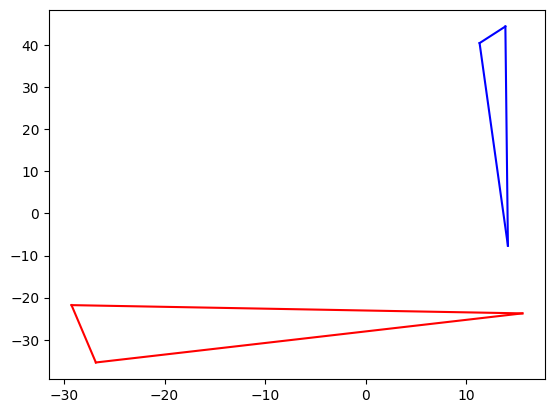

In [ ]:
# Exemplo de uso
pontos1 = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(3)]
pontos2 = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(3)]
envoltoria1 = graham_scan(pontos1)
envoltoria2 = graham_scan(pontos2)
plot_envoltorias(envoltoria1, envoltoria2)